# Compute TNG-300-1 halo and galaxy properties (matching TNG-300-1-Dark for halo properties)

In [1]:
import illustris_python as il
import pandas as pd
import numpy as np
import h5py
from scipy.optimize import fsolve
from scipy import spatial
import matplotlib.pyplot as plt
from astropy.visualization import hist

### 1. Read group and subhalo catalogs for TNG-300-1 run

In [2]:
basePath_hydro = '/home/shihong/Documents/sibelius_dark_ml/deSanti_2021/TNG300-1/output/'
snapIndex_hydro = 99

Load header information. The box size will be used to search neighboring subhalos

In [3]:
header_hydro = il.groupcat.loadHeader(basePath_hydro, snapIndex_hydro)

Load FOF group catalog.

In [4]:
fields = ['GroupFirstSub', 'Group_M_Crit200', 'Group_R_Crit200', 'GroupNsubs']
halos_hydro = il.groupcat.loadHalos(basePath_hydro, snapIndex_hydro, fields=fields)
print('TNG-300-1 FOF group number: %d' % (halos_hydro['count']))

TNG-300-1 FOF group number: 17625892


Load subhalo catalog.

In [5]:
fields = ['SubhaloFlag', 'SubhaloGrNr', 'SubhaloPos', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMassType', 'SubhaloSFR', 'SubhaloSpin', 'SubhaloHalfmassRadType', 'SubhaloStellarPhotometrics', 'SubhaloVmax']
subhalos_hydro = il.groupcat.loadSubhalos(basePath_hydro, snapIndex_hydro, fields=fields)
print('TNG-300-1 subhalo number: %d' % (subhalos_hydro['count']))

TNG-300-1 subhalo number: 14485709


### 2. Read group and subhalo catalogs for TNG-300-1-Dark run

In [6]:
basePath_dark = '/home/shihong/Documents/sibelius_dark_ml/deSanti_2021/TNG300-1-Dark/output/'
snapIndex_dark = 99

In [7]:
header_dark = il.groupcat.loadHeader(basePath_dark, snapIndex_dark)

fields = ['GroupFirstSub', 'Group_M_Crit200', 'Group_R_Crit200', 'GroupNsubs']
halos_dark = il.groupcat.loadHalos(basePath_dark, snapIndex_dark, fields=fields)
print('TNG-300-1-Dark FOF group number: %d' % (halos_dark['count']))

fields = ['SubhaloGrNr', 'SubhaloPos', 'SubhaloLen', 'SubhaloSpin', 'SubhaloVmax']
subhalos_dark = il.groupcat.loadSubhalos(basePath_dark, snapIndex_dark, fields=fields)
print('TNG-300-1-Dark subhalo number: %d' % (subhalos_dark['count']))

TNG-300-1-Dark FOF group number: 13008511
TNG-300-1-Dark subhalo number: 15724587


### 3. Read halo structure catalog for TNG-300-1-Dark

We will use the halo formation time from this catalog. Note that this catalog is for halos in the FOF group catalog only.

In [8]:
path = '/home/shihong/Documents/sibelius_dark_ml/deSanti_2021/TNG300-1-Dark/postprocessing/halo_structure/halo_structure_099.hdf5'
haloStructure_dark = h5py.File(path, 'r')
a_form_dark = np.array(haloStructure_dark['a_form'])

### 4. Read subhalo matching file

In [9]:
path = '/home/shihong/Documents/sibelius_dark_ml/deSanti_2021/TNG300-1/postprocessing/matching/subhalo_matching_to_dark.hdf5'
subhaloMatchingFile = h5py.File(path, 'r')
subhaloMatch = np.array(subhaloMatchingFile['Snapshot_%d' % (snapIndex_dark)]['SubhaloIndexDark_SubLink'])
print('Subhalo match array length: %d' % (len(subhaloMatch)))

Subhalo match array length: 14485709


### 5. Select subhalo samples

The selection criteria are:

(1) central galaxies, 

(2) virial mass M200 >= 10^10.5 Msol/h,

(3) total stellar mass M* >= 10^8.75 Msol/h,

(4) 'SubhaloFlag' in the subhalo catalog is non-zero,

(5) the suhalo is able to find a matched counterpart in TNG-300-1-Dark run,

(6) the selected subhalo should have the formation time computed from the halo structure catalog.

In [10]:
totSubhaloNum_hydro = len(subhalos_hydro['SubhaloFlag'])
selectSubhaloIndex_hydro = np.full(totSubhaloNum_hydro, False)

fofCatalogCriteria = halos_hydro['Group_M_Crit200']*1e10 >= 10**10.5  # Criteria (2)
selectSubhaloIndex_hydro[halos_hydro['GroupFirstSub'][fofCatalogCriteria]] = True  # Criterion (1)
subhaloStellarMass = (subhalos_hydro['SubhaloMassType'].T)[4] * 1e10
selectSubhaloIndex_hydro[subhaloStellarMass < 10**8.75] = False  # Criterion (3)
selectSubhaloIndex_hydro[subhalos_hydro['SubhaloFlag'] == 0] = False  # Criterion (4)
selectSubhaloIndex_hydro[subhaloMatch < 0] = False  # Criterion (5)

# Criterion (6)
for i in range(totSubhaloNum_hydro):
  if selectSubhaloIndex_hydro[i]:
    matchIndex = subhaloMatch[i]
    condition = a_form_dark[subhalos_dark['SubhaloGrNr'][matchIndex]] > 0.0
    if condition == False:
      selectSubhaloIndex_hydro[i] = False

                            

selectSubhaloNum_hydro = len(subhalos_hydro['SubhaloFlag'][selectSubhaloIndex_hydro])
gasLen = (subhalos_hydro['SubhaloLenType'].T)[0]
starLen = (subhalos_hydro['SubhaloLenType'].T)[4]

print('Total number of subhalos in TNG300-1: %d' % (totSubhaloNum_hydro))
print('Number of selected subhalos for this study: %d' % (selectSubhaloNum_hydro))
print('Minimum total particle number of selected subhalos: %d' % (np.min(subhalos_hydro['SubhaloLen'][selectSubhaloIndex_hydro])))
print('Minimum gas cell number of selected subhalos: %d' % (np.min(gasLen[selectSubhaloIndex_hydro])))
print('Minimum star particle number of selected subhalos: %d' % (np.min(starLen[selectSubhaloIndex_hydro])))

Total number of subhalos in TNG300-1: 14485709
Number of selected subhalos for this study: 173453
Minimum total particle number of selected subhalos: 848
Minimum gas cell number of selected subhalos: 0
Minimum star particle number of selected subhalos: 86


### 6. Retrieve/Compute halo/galaxy properties for selected subhalos

#### Virial mass (Msol/h)

Text(0.5, 0, 'log$_{10}$ $M_\\mathrm{vir}[h^{-1}M_\\odot]$')

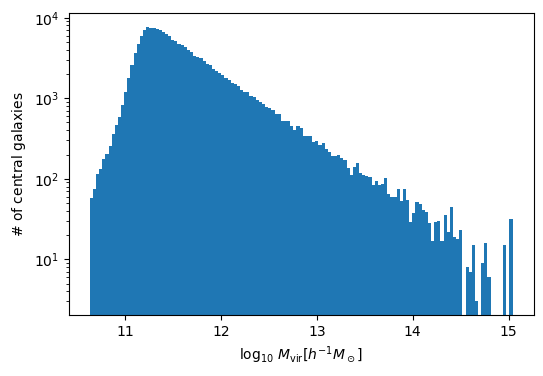

In [11]:
selectSubhaloIndex_dark = subhaloMatch[selectSubhaloIndex_hydro]
selectSubhaloGrNr_dark = subhalos_dark['SubhaloGrNr'][selectSubhaloIndex_dark]
Mvir_in_Msol = halos_dark['Group_M_Crit200'][selectSubhaloGrNr_dark] * 1e10

plt.figure(dpi = 100)
hist(np.log10(Mvir_in_Msol), bins = 'scott')
plt.yscale('log')
plt.ylabel('$\#$ of central galaxies')
plt.xlabel('log$_{10}$ $M_\mathrm{vir}[h^{-1}M_\odot]$')

#### Formation time (redshift)

Text(0.5, 0, '$z_\\mathrm{form}$')

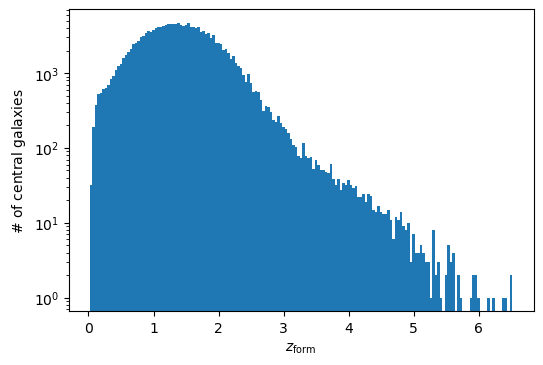

In [12]:
z_form = 1. / a_form_dark[selectSubhaloGrNr_dark] - 1.

plt.figure(dpi = 100)
hist(z_form, bins = 'scott')
plt.yscale('log')
plt.ylabel('$\#$ of central galaxies')
plt.xlabel('$z_\mathrm{form}$')

#### Spin parameter

As a quick estimation, use the specific angular momentum information in the subhalo catalog, and the virial mass and virial radius from the group catalog to compute according to the Bullock et al. (2001) definition.

Text(0.5, 0, 'log$_{10} \\lambda$')

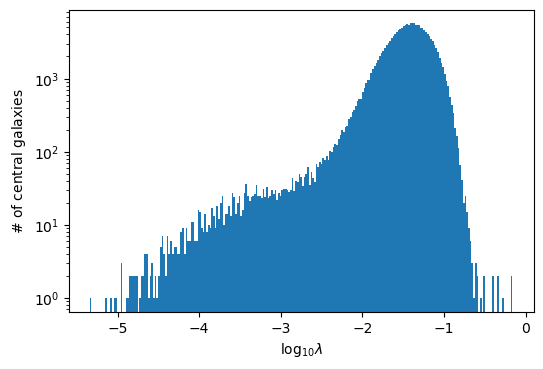

In [13]:
Mvir = halos_dark['Group_M_Crit200'][selectSubhaloGrNr_dark]
Rvir = halos_dark['Group_R_Crit200'][selectSubhaloGrNr_dark]
G_const = 43007.1
Vvir = (G_const * Mvir / Rvir)**0.5
subhaloSpin = subhalos_dark['SubhaloSpin'].T
j = (subhaloSpin[0][selectSubhaloIndex_dark]**2. + subhaloSpin[1][selectSubhaloIndex_dark]**2. + subhaloSpin[2][selectSubhaloIndex_dark]**2.)**0.5
spinParam = j / (2**0.5 * Vvir * Rvir)

plt.figure(dpi = 100)
hist(np.log10(spinParam), bins = 'scott')
plt.yscale('log')
plt.ylabel('$\#$ of central galaxies')
plt.xlabel('log$_{10} \lambda$')

#### Concentration

Assume an NFW density profile, numerically sovle c200 from the ratio of Vmax/V200.

/home/local/shihong/Libraries/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/tmp/ipykernel_1888/56356432.py:2: RuntimeWarning: invalid value encountered in log
  return np.log(1. + x) - x / (1. + x)
/tmp/ipykernel_1888/56356432.py:5: RuntimeWarning: invalid value encountered in sqrt
  return Vmax/V200 - (0.216 * x / func(x))**0.5
/home/local/shihong/Libraries/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Text(0.5, 0, 'Concentration')

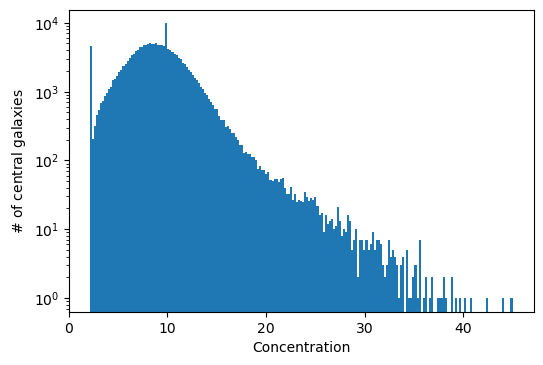

In [14]:
def func(x):
  return np.log(1. + x) - x / (1. + x)

def solve_func(x, Vmax, V200):
  return Vmax/V200 - (0.216 * x / func(x))**0.5

Vmax = subhalos_dark['SubhaloVmax'][selectSubhaloIndex_dark]
cvir = np.arange(selectSubhaloNum_hydro, dtype='float64')
for i in range(selectSubhaloNum_hydro):
  cvir[i] = fsolve(solve_func, x0=10., args=(Vmax[i], Vvir[i]))

plt.figure(dpi = 100)
hist(cvir, bins = 'scott')
plt.yscale('log')
plt.ylabel('$\#$ of central galaxies')
plt.xlabel('Concentration')

#### Overdensity on a 3 Mpc/h scale

Use KD-Tree for neighboring search.

Text(0.5, 0, 'log$_{10}$ $\\Delta_{3Mpc}$')

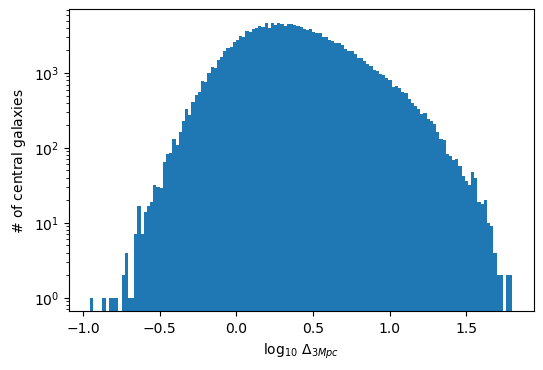

In [15]:
Delta3_h = np.zeros(selectSubhaloNum_hydro, dtype='float64')
environmentRadius = 3000.0  # in kpc/h

boxSize = header_dark['BoxSize']
allSubhaloPos = subhalos_dark['SubhaloPos']
allSubhaloPos = allSubhaloPos.T
for i in range(3):
  allSubhaloPos[i][allSubhaloPos[i] >= boxSize] = allSubhaloPos[i][allSubhaloPos[i] >= boxSize] - boxSize
  allSubhaloPos[i][allSubhaloPos[i] < 0.0] = allSubhaloPos[i][allSubhaloPos[i] < 0.0] + boxSize

allSubhaloPos = allSubhaloPos.T
tree = spatial.cKDTree(allSubhaloPos, boxsize=boxSize)

selectSubhaloPos = subhalos_dark['SubhaloPos'][selectSubhaloIndex_dark]

for i in range(selectSubhaloNum_hydro):
  allNeighborList = tree.query_ball_point(selectSubhaloPos[i], environmentRadius)
  sameHaloNeighborList = tree.query_ball_point(selectSubhaloPos[i], halos_dark['Group_R_Crit200'][selectSubhaloGrNr_dark[i]])
  Delta3_h[i] = len(allNeighborList) - len(sameHaloNeighborList)

meanSubhaloNumDen = totSubhaloNum_hydro / boxSize**3.0
sphereVol = 4. * np.pi * environmentRadius**3. / 3.
Delta3_h = Delta3_h / sphereVol / meanSubhaloNumDen

plt.figure(dpi = 100)
hist(np.log10(Delta3_h), bins = 'scott')
plt.yscale('log')
plt.ylabel('$\#$ of central galaxies')
plt.xlabel('log$_{10}$ $\Delta_{3Mpc}$')

#### SFR (Msol/yr)

In [16]:
SFR_in_Msol_per_yr = subhalos_hydro['SubhaloSFR'][selectSubhaloIndex_hydro]

#### Stellar mass (Msol)

Text(0.5, 0, 'log$_{10}$ $M_\\star[h^{-1}M_\\odot]$')

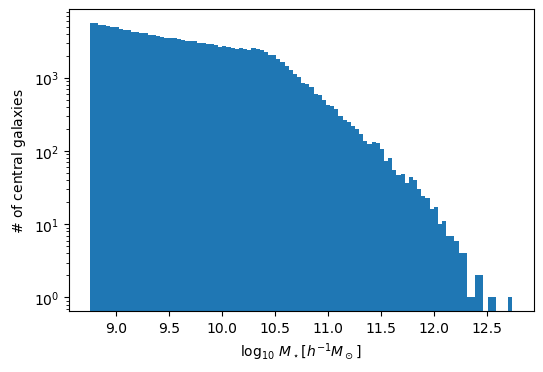

In [17]:
Mstar_in_Msol = (subhalos_hydro['SubhaloMassType'].T)[4][selectSubhaloIndex_hydro] * 1e10

plt.figure(dpi = 100)
hist(np.log10(Mstar_in_Msol), bins = 'scott')
plt.yscale('log')
plt.ylabel('$\#$ of central galaxies')
plt.xlabel('log$_{10}$ $M_\star[h^{-1}M_\odot]$')

#### sSFR (yr^-1)

Note that as mentioned in de Santi et al. (2021), ~14% of the galaxies in TNG300-1 have SFR = 0, which originates from the numerical resolution. Following the authors, for these null-SFR galaxies, generate an non-zero log sSFR for them from a Gaussian distribution with the mean of -13.5 and sigma of 0.5 (see their Section 2.2 for details).

Zero sSFR number: 24389
Zero sSFR Fraction: 0.140609


Text(0.5, 0, 'log$_{10}$ sSFR [yr$^{-1}$]')

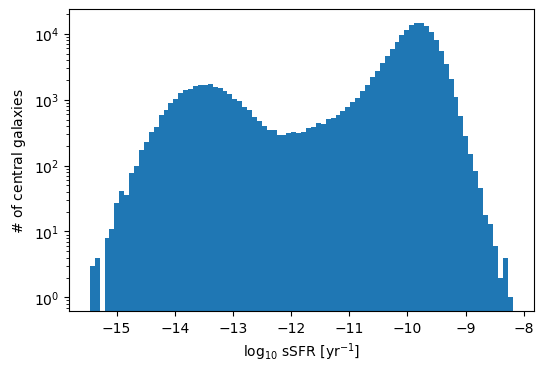

In [18]:
sSFR_in_per_yr = SFR_in_Msol_per_yr / Mstar_in_Msol
zerosSFRNum = len(sSFR_in_per_yr[sSFR_in_per_yr == 0.0])
print('Zero sSFR number: %d' % (zerosSFRNum))
print('Zero sSFR Fraction: %g' % (float(zerosSFRNum) / selectSubhaloNum_hydro))

np.random.seed(42)
gaussianLogsSFR = np.random.normal(-13.5, 0.5, zerosSFRNum)
sSFR_in_per_yr[sSFR_in_per_yr == 0.0] = 10.**gaussianLogsSFR

plt.figure(dpi = 100)
hist(np.log10(sSFR_in_per_yr), bins = 'scott')
plt.yscale('log')
plt.ylabel('$\#$ of central galaxies')
plt.xlabel('log$_{10}$ sSFR [yr$^{-1}$]')

#### g-i color

Text(0.5, 0, '$g-i$')

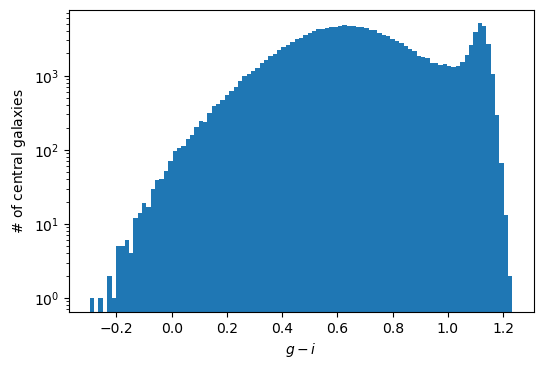

In [19]:
g_i_color = (subhalos_hydro['SubhaloStellarPhotometrics'].T)[4][selectSubhaloIndex_hydro] - (subhalos_hydro['SubhaloStellarPhotometrics'].T)[6][selectSubhaloIndex_hydro]

plt.figure(dpi = 100)
hist(g_i_color, bins = 'scott')
plt.yscale('log')
plt.ylabel('$\#$ of central galaxies')
plt.xlabel('$g-i$')

#### Stellar half-mass radius (kpc/h)

Text(0.5, 0, 'log$_{10} R_{1/2} [h^{-1} \\mathrm{kpc}]$')

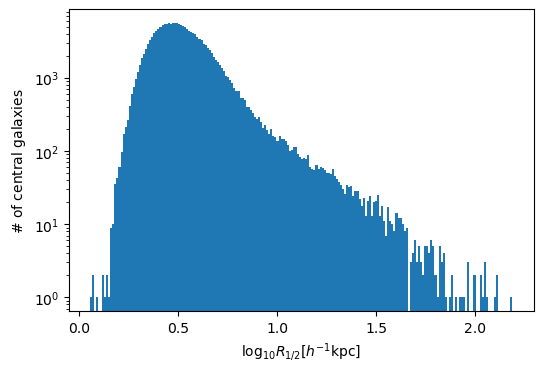

In [20]:
stellarHalfmassRad_in_kpc = (subhalos_hydro['SubhaloHalfmassRadType'].T)[4][selectSubhaloIndex_hydro]

plt.figure(dpi = 100)
hist(np.log10(stellarHalfmassRad_in_kpc), bins = 'scott')
plt.yscale('log')
plt.ylabel('$\#$ of central galaxies')
plt.xlabel('log$_{10} R_{1/2} [h^{-1} \mathrm{kpc}]$')

### 7. Construct data frame with pandas and output

By reading the jupyter notebook code in github for de Santi et al. (2021), the virial mass, concentration, stellar mass, sSFR, and stellar half-mass radius in the output .csv file should be logarithmic.

In [21]:
d = {}
d['M_h'] = np.log10(Mvir_in_Msol)
d['C_h'] = np.log10(cvir)
d['S_h'] = spinParam
d['z_h'] = z_form
d['Delta3_h'] = Delta3_h
d['stellar_mass'] = np.log10(Mstar_in_Msol)
d['sSFR'] = np.log10(sSFR_in_per_yr)
d['radius'] = np.log10(stellarHalfmassRad_in_kpc)
d['color'] = g_i_color

df = pd.DataFrame(data=d)
df.to_csv('./IllustrisTNG_match_dark_run.csv', index=False)